The following cell is given to help you download necessary datasets for this homework. It requires certain tool to be installed in your environment. You can either use this cell to download the datasets or manually download them on the corresponding websites.

In [1]:
# Get necessary datasets; this cell only needs to be run once
!if [ -e "MNIST" ];then rm -rf "MNIST" ; fi
!if [ -e "CIFAR-10" ];then rm -rf "CIFAR-10" ; fi

!mkdir MNIST
%cd MNIST
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz
%cd ..

!mkdir CIFAR-10
%cd CIFAR-10
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz
%cd ..

/content/MNIST
--2022-11-18 06:52:46--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3120::, ...
Connecting to yann.lecun.com (yann.lecun.com)|188.114.97.0|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.07s   

2022-11-18 06:52:46 (137 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2022-11-18 06:52:46--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3120::, ...
Connecting to yann.lecun.com (yann.lecun.com)|188.114.97.0|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[=================

# 2. Training a small CNN for MNIST digit classification

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import struct
from torch.utils.data import Dataset
import random
import os
import struct
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

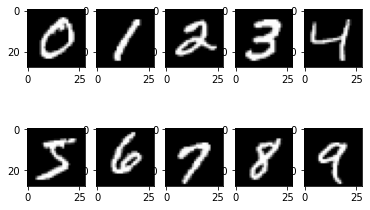

In [3]:
# DATA PARSING
# You can manually download the data from http://yann.lecun.com/exdb/mnist/ and set path
path = "./MNIST/"

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
torchTrainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
torchTestData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

plt.figure()
for i in range(10):
    ind=np.where(trainLabels==i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(trainData[ind][:,:,0],cmap='gray')
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self,drop):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5,stride=1,padding=2,bias=True)
        self.max1 = nn.MaxPool2d(2,stride=2)
        self.conv2 = nn.Conv2d(32, 64, 5,stride=1,padding=2,bias=True)
        self.max2 = nn.MaxPool2d(2,stride=2)
        self.fc1=nn.Linear(3136,1024)
        if(drop):
            self.drop=nn.Dropout(p=0.4)
        else:
            self.drop=None
        self.fc2=nn.Linear(1024,10)
        
    def forward(self, x):
        x = self.max1(F.relu(self.conv1(x)))
        x = self.max2(F.relu(self.conv2(x)))
        x = F.relu(self.fc1(x.reshape(-1,3136)))
        if(self.drop):
            x=self.drop(x)
        x = self.fc2(x)
        
        return x
    
net = Net(drop=True)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


In [5]:
def train(tdata,tlabel,net,to_train,opt,batch=200):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acc=[]
    epochs=15
    learning_rate=1e-3
    if(opt=='adam'):
        optimizer = optim.Adam(to_train,lr=learning_rate)
    else:
        optimizer = optim.SGD(to_train,lr=learning_rate,momentum = 0.99)
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            optimizer.zero_grad()
            prediction = net(inputs)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            losslist.append(loss.data.cpu().numpy())
            acc.append(np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel[inds]))

    return losslist,acc

def test(tdata,tlabel,net):
    inputs = Variable(torch.FloatTensor(tdata).cuda())
    targets = Variable(torch.LongTensor(tlabel).cuda())
    prediction = net(inputs)
    acc=np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel)

    return acc

100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


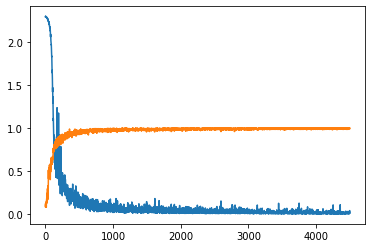

0.9893


In [6]:
net = Net(drop=False).cuda()
x1,a1=train(torchTrainData,trainLabels,net,net.parameters(),'sgd')
ax=range(len(x1))
plt.plot(ax,x1,ax,a1)
plt.show()
print(test(torchTestData,testLabels,net))

100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


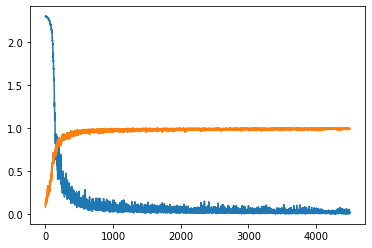

0.9893


In [7]:
net = Net(drop=True).cuda()
x2,a2=train(torchTrainData,trainLabels,net,net.parameters(),'sgd')
ax=range(len(x2))
plt.plot(ax,x2,ax,a2)
plt.show()
print(test(torchTestData,testLabels,net))

100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


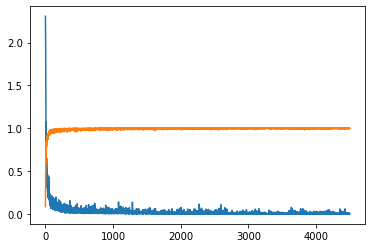

0.00042194332
1.0


In [8]:
net = Net(drop=False).cuda()
x3,a3=train(torchTrainData,trainLabels,net,net.parameters(),'adam')
ax=range(len(x3))
plt.plot(ax,x3,ax,a3)
plt.show()
print(x3[-1])
print(a3[-1])

100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


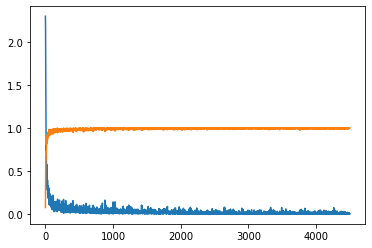

0.00030138847
1.0


In [9]:
net = Net(drop=True).cuda()
x4,a4=train(torchTrainData,trainLabels,net,net.parameters(),'adam')
ax=range(len(x4))
plt.plot(ax,x4,ax,a4)
plt.show()
print(x4[-1])
print(a4[-1])

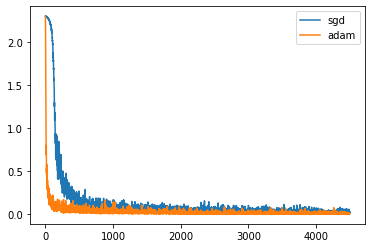

In [10]:
ax=range(len(x2))
plt.plot(ax,x2,ax,x4)
plt.legend(['sgd','adam'])
plt.show()

In [11]:
net = Net(drop=True).cuda()
x1,_=train(torchTrainData,trainLabels,net,net.parameters(),'adam',100)
net = Net(drop=True).cuda()
x2,_=train(torchTrainData,trainLabels,net,net.parameters(),'adam',300)
net = Net(drop=True).cuda()
x3,_=train(torchTrainData,trainLabels,net,net.parameters(),'adam',1000)

100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


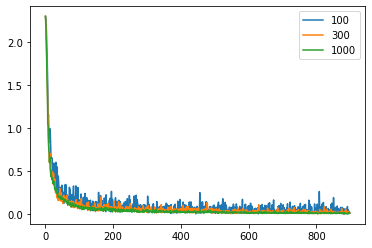

In [12]:
ax=range(len(x3))
plt.plot(ax,x1[:len(x3)],ax,x2[:len(x3)],ax,x3)
plt.legend(['100','300','1000'])
plt.show()

# 3. Transfer Learning

In [13]:
# DATA PARSING
# You can manually download the data from from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and set path
path='./CIFAR-10/cifar-10-batches-py/'
data=np.zeros((0,32,32,3))
labels=[]
for i in range(1,6):
    with open(path+'data_batch_'+str(i), 'rb') as fo:
        dat = pickle.load(fo,encoding='latin1')
        r=dat['data'][:,:1024*1].reshape((10000,32,32,1))
        g=dat['data'][:,1024:2048].reshape((10000,32,32,1))
        b=dat['data'][:,2048:3072].reshape((10000,32,32,1))
        rgb=np.concatenate((r,g,b),axis=3)
        data=np.vstack((data,np.float32(rgb)/255))
        labels+=dat['labels']
labels=np.array(labels)
# data -> 50000 X 32 X 32 X 3 array with training data
# labels -> 50000 labels ranging from 0 to 9

Plot 3 random images corresponding to each label from the training data - 2 points

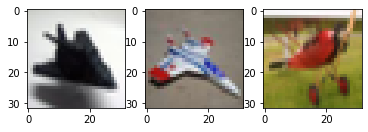

In [14]:
for i in range(1):
    temp=data[labels==i]
    for j in range(3):
        plt.subplot(1,3,j+1)
        plt.imshow(temp[j])
    plt.show()

1. Split the data and labels into 2 sets, first one containing labels 0 to 4, and second one from 5 to 9. 
3. Store them in data1, labels1, data2 and labels2 - 3 points

In [15]:
data1=np.zeros((0,32,32,3))
labels1=[]
data2=np.zeros((0,32,32,3))
labels2=[]
for i in range(5):
    x=data[labels==i]
    data1=np.vstack((data1,x))
    labels1+=[i]*len(x)
for i in range(5,10):
    x=data[labels==i]
    data2=np.vstack((data2,x))
    labels2+=[i-5]*len(x)
    
labels1=np.array(labels1)
labels2=np.array(labels2)

torch_data1=data1.transpose((0,3,1,2))
torch_data2=data2.transpose((0,3,1,2))

Create a simple convolutional network to classify the training data. The network structure should be as follows:
1. Layer 1 - Kernel size 4, Stride 2, Output channels 5, Bias enabled, Relu activation
2. Layer 2 - Kernel size 4, Stride 1, Output channels 10, Bias enabled, Relu avtication
3. Layer 3 - Kernel size 4, Stride 1, Output channels 20, Bias enabled, Relu activation
4. Layer 4 - Kernel size 4, Stride 1, Output channels 40, Bias enabled, Relu activation
5. Layer 5 - Fully connected layer with 5 outputs

Refer to https://github.com/ameykusurkar/pytorch-image-classifier/blob/master/main.py for help from this section onwards, but note that torchvision.transforms is not required since we already have the data in the required format - 3 points

In [16]:
n=5
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, n, 4,stride=2,bias=True)
        self.conv2 = nn.Conv2d(n, 2*n, 4,stride=1,bias=True)
        self.conv3 = nn.Conv2d(2*n, 4*n, 4,stride=1,bias=True)
        self.conv4 = nn.Conv2d(4*n, 8*n, 4,stride=1,bias=True)
        self.fc=nn.Linear(6*6*8*n,5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.fc(x.reshape(-1,6*6*8*n))
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(5, 10, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc): Linear(in_features=1440, out_features=5, bias=True)
)


Create a function that trains the network using the provided data. However it should only train the part of the network that is passed in as a parameter. - 6 points
1. Training data must be randomly sampled to obtain a batch of data which is a subset of the whole training dataset at every iteration
2. Use the Adam optimizer and CrossEntropyLoss function
3. Store the loss as well as the accuracy of the network on the training data at every iteration and return them in arrays at the end

In [17]:
# to_train can be net.paramaters OR net.fc.parameters OR net.conv1.parameters so that only certain parts of the net are trained
def train(tdata,tlabel,net,to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acc=[]
    epochs=10
    batch=500
    learning_rate=1e-3
    optimizer = optim.Adam(to_train,lr=learning_rate)
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            optimizer.zero_grad()
            prediction = net(inputs)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            losslist.append(loss.data.cpu().numpy())
            acc.append(np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel[inds]))

    return losslist,acc

Initialize the network, train the complete network (net.parameters) on data1 (The first 5 classes) and plot the loss and accuracy vs iterations on the same graph. Print the final loss and accuracy as well. Set the learning rate, number of iterations and batch size such that the loss is gradually and smoothly decreasing and converging. The accuracy at the end of training must be around or greater than 60 %. Suggested parameters are - batch size > 300, learning rate in the order of 1e-3 and at least 10 epochs iterations for these parameters. - 5 points

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


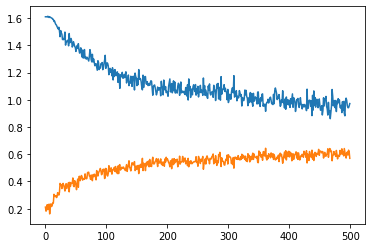

0.972147
0.57


In [18]:
# Initialize net
net = Net().cuda()
x1,a1=train(torch_data1,labels1,net,net.parameters())
ax=range(len(x1))
plt.plot(ax,x1,ax,a1)
plt.show()
print(x1[-1])
print(a1[-1])

Without reinitializing the network, train only the fully connected layer (net.fc.parameters) now on data2 (The next 5 classes). Do not change any hyper parameters such as learning rate or batch size. Plot the loss and accuracy and print the final values like before. - 2 points

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


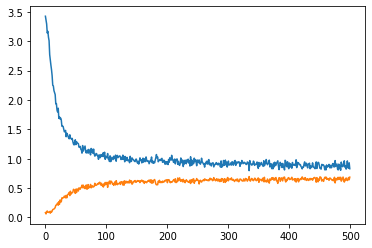

0.8297986
0.686


In [19]:
x2,a2=train(torch_data2,labels2,net,net.fc.parameters())
ax=range(len(x2))
plt.plot(ax,x2,ax,a2)
plt.show()
print(x2[-1])
print(a2[-1])

Now repeat the process in the opposite order. Initialize the net again, train the whole network on data2, generate the same plots as before, and then without reinitializing the net, train only the fully connected layer on data1 and generate the plots. Do not change any hyperparameters. - 3 points

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


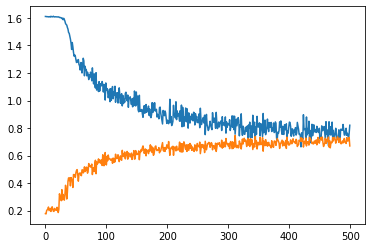

0.8204065
0.67


In [20]:
# Initialize net
net = Net().cuda()
x3,a3=train(torch_data2,labels2,net,net.parameters())
ax=range(len(x3))
plt.plot(ax,x3,ax,a3)
plt.show()
print(x3[-1])
print(a3[-1])

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


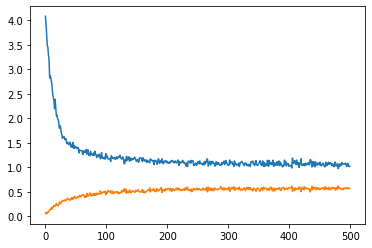

1.0245465
0.58


In [21]:
x4,a4=train(torch_data1,labels1,net,net.fc.parameters())
ax=range(len(x4))
plt.plot(ax,x4,ax,a4)
plt.show()
print(x4[-1])
print(a4[-1])

Plot the loss vs iterations for the classifers trained to classify data1, via normal learning as well as transfer learning, on the same graph. Plot another graph for the classifiers trained to classify data2. Explain the results obtained, based on the training regimen. Comment on why transfer learning worked/didn't work. - 5 points

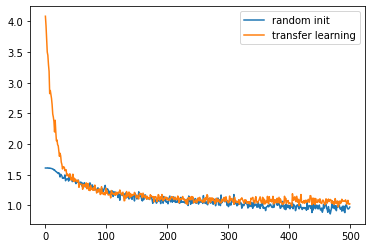

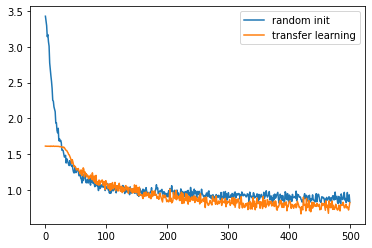

In [22]:
ax=range(len(x1))
plt.plot(ax,x1,ax,x4)
plt.legend(['random init','transfer learning'])
plt.show()

ax=range(len(x2))
plt.plot(ax,x2,ax,x3)
plt.legend(['random init','transfer learning'])
plt.show()

Create a network with more layers, pooling layers, and more filters and try to increase accuracy as much as possible. Play around with the hyperparameters to understand how they affect the training process. No need to turn anything in. - 0 points